# **0. 변수명 통일**
- `user_prompt`: 만들고자 하는 이미지
- `original_image`: user_prompt로 만든 초안 이미지
- `image_caption`: original_image에 대한 캡션된 문장
- `similarity_score`: user_prompt와 image_caption 사이의 문장 유사도
- `regenerated_image`: case1,2를 통해 재생성된 이미지
- `incorrect_objects`: 잘못 그린/고쳐야 하는 객체(들)
- `masked_image`: 마스킹 된 이미지
- `original_score`: original_image의 clip 점수
- `modified_score`: regenerated_image의 clip 점수

# **1. Install, Import, Device**

In [1]:
# 설치 
# !pip install -U diffusers transformers accelerate safetensors invisible_watermark
# !pip install -U sentence-transformers torchvision

In [1]:
# 라이브러리
import torch
import torch.nn.functional as F
from diffusers import DiffusionPipeline, AutoPipelineForText2Image #TTI
from transformers import AutoProcessor, Blip2ForConditionalGeneration # BLIP2
from sentence_transformers import SentenceTransformer, util # STS
from diffusers import StableDiffusionInstructPix2PixPipeline # Case1
from transformers import CLIPProcessor, CLIPModel # CLIP

import requests
from PIL import Image
from io import BytesIO
from diffusers.utils import load_image
from IPython.display import display


# 런타임 유형 T4 GPU로 설정해야함. (TPU는 hugging face랑 호환이 안맞고 cpu는 너무 느림)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"currently using device: {device}") # 올바르게 설정했다면 "cuda"가 떠야 함

c:\Users\miche\projects\TTI_Alignment\IG_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


currently using device: cpu


# **2. Dataset - `PartiPrompt`**
* PartiPrompt에서 challenge 카테고리를 기준으로 선정 (노션 참고)
* for more visit [here](https://huggingface.co/datasets/nateraw/parti-prompts/viewer/default/train?f[Challenge][value]=%27Fine-grained%20Detail%27&sort[column]=Category&sort[direction]=desc)

In [2]:
user_prompts = ["a photograph of a bird wearing headphones and speaking into a microphone in a recording studio",
                "a boy jumping off a wall",
                "a cat drinking a pint of beer",
                "A donkey is playing tug-of-war against an octopus. The donkey holds the rope in its mouth. A cat is jumping over the rope.",
                "three black cats standing next to two orange cats",
                "A man sips a latte and a woman a beer.",
                "three small yellow boxes on a large blue box."]

# **3. Generate Original Image**
* SDXL-Turbo 모델의 좋은 시드가 공개됨
* 좋은 시드 (FID benchmark 기준 좋은 순서대로)
    * 511, 781, 560, 866, 574, ...
    * for more visit: [here](https://arxiv.org/pdf/2405.14828v1)
    * 일단 511로 고정시켜서 테스트 해봅시당

In [3]:
SDXL_model = AutoPipelineForText2Image.from_pretrained("stabilityai/sdxl-turbo", torch_dtype=torch.float16, variant="fp16")
SDXL_model.to(device)

Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00,  7.05it/s]
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fai

StableDiffusionXLPipeline {
  "_class_name": "StableDiffusionXLPipeline",
  "_diffusers_version": "0.32.2",
  "_name_or_path": "stabilityai/sdxl-turbo",
  "feature_extractor": [
    null,
    null
  ],
  "force_zeros_for_empty_prompt": true,
  "image_encoder": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "EulerAncestralDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

100%|██████████| 1/1 [08:21<00:00, 501.95s/it]


three black cats standing next to two orange cats


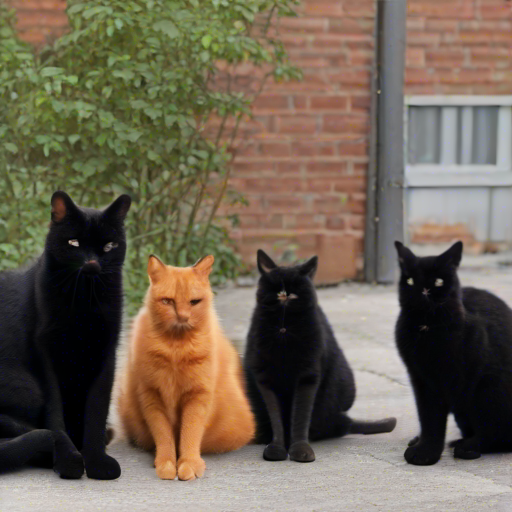

In [4]:
# 시드 고정 -- 일단은 511로
SDXL_seed = 511
SDXL_generator = torch.Generator(device).manual_seed(SDXL_seed)

user_prompt = user_prompts[4] # 어떤 프롬프트 쓸건지 정하기 (범위: 0~6)

original_image = SDXL_model(prompt=user_prompt,
                            num_inference_steps=1,
                            guidance_scale=0.0,
                            generator=SDXL_generator).images[0]

print(user_prompt)
display(original_image)

# **4. Image Captioning**
* 모델: BLIP-2
* adaptive captioning: 캡셔닝 토큰 길이를 `user_prompt` 길이에 맞춰서 adaptive 하게 생성하여 STS 모델이 공정하게 점수를 측정할 수 있도록 돕는다.

In [5]:
blip2_processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
blip2_model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", torch_dtype=torch.float32)
blip2_model.to(device)

c:\Users\miche\projects\TTI_Alignment\IG_venv\Lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\miche\.cache\huggingface\hub\models--Salesforce--blip2-opt-2.7b. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this mode

Blip2ForConditionalGeneration(
  (vision_model): Blip2VisionModel(
    (embeddings): Blip2VisionEmbeddings(
      (patch_embedding): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14))
    )
    (encoder): Blip2Encoder(
      (layers): ModuleList(
        (0-38): 39 x Blip2EncoderLayer(
          (self_attn): Blip2Attention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=1408, out_features=4224, bias=True)
            (projection): Linear(in_features=1408, out_features=1408, bias=True)
          )
          (layer_norm1): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
          (mlp): Blip2MLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1408, out_features=6144, bias=True)
            (fc2): Linear(in_features=6144, out_features=1408, bias=True)
          )
          (layer_norm2): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((

In [6]:
user_prompt_len = len(user_prompt) # user prompt 길이로 캡셔닝 토큰 수 제한
input_image = blip2_processor(original_image, return_tensors="pt").to(device, torch.float16)

generated_ids = blip2_model.generate(**input_image, max_new_tokens=user_prompt_len)
image_caption = blip2_processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(image_caption)

a group of cats sitting on the ground


## **5. Compute Similarity Score (by STS)**
- 모델: sentence transformer

In [7]:
STS_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

# 문장 임베딩 생성
prompt_embedding = STS_model.encode(user_prompt, convert_to_tensor=True)
caption_embedding = STS_model.encode(image_caption, convert_to_tensor=True)

# 문장 간 유사도 측정
similarity_score = util.cos_sim(prompt_embedding, caption_embedding)

print(f"Similarity score between prompt and caption: {similarity_score.item():.4f}")

c:\Users\miche\projects\TTI_Alignment\IG_venv\Lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\miche\.cache\huggingface\hub\models--sentence-transformers--all-mpnet-base-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Similarity score between prompt and caption: 0.4724


# **6. Case Decision by Similarity Score**
- `similarity_score > threshold`: case1
- `similarity_score ≤ threshold`: case2

In [8]:
threshold = 0.7 # 실험적으로 optimal threshold 찾기
case_num = -1

if similarity_score < threshold:
    case_num = 1
else:
    case_num = 2

## **7.1. Case1**
- 이미지 전체 재생성
- 모델 선정 이슈
    - SDXL-Turbo는 SDXL의 속도 최적화 버전으로 훨씬 빠르면서도 괜찮은 이미지 품질을 냄. 하지만 텍스트를 섬세하게 반영하는 정밀도는 떨어짐.
    - Case1에서처럼 프롬프트를 주면서 재생성하고자 할 때는 (GPT왈,) 다른 모델 추천
- 후보 모델 -> 일단 `InstructPix2Pix` 로 도전
    1. `InstructPix2Pix`: 텍스트 명령어로 기존 이미지를 수정하는 데 최적화된 모델
    2. `T2I-Adapter`: 기존 이미지를 구조 정보로 활용하고, 텍스트로 제어
    3. `SDXL (base)`: SDXL Turbo보다 훨씬 정밀하고, 다양한 조건을 더 잘 반영. 느리지만 복잡한 prompt 처리에 더 적합.
- <font color='red'> 그래서 이미지를 재생성하는 모델과 원본 이미지 생성하는 모델을 일치시킬 것이냐 그대로 둘 것이냐..</font>

In [13]:
# 캐시 정리
torch.cuda.empty_cache()

# InstructPix2Pix 로드 (GPU 올리지 않음)
pix2pix_pipe = StableDiffusionInstructPix2PixPipeline.from_pretrained(
    "timbrooks/instruct-pix2pix", safety_checker=None
).to(device)

Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00, 29.93it/s]


In [14]:
if case_num == 1:
    # 수정 prompt
    edit_prompt = (f"""The user prompt was: '{user_prompt}',
                       but the generated image was captioned as: '{image_caption}'.
                       Considering the difference between them, modify the image to better reflect the user's intent."""
    )

    # 이미지 재생성 (inference)
    with torch.no_grad():
        regenerated_image = pix2pix_pipe(image=original_image,
                                         prompt=edit_prompt,
                                         num_inference_steps=20,
                                         guidance_scale=7.5,
                                         image_guidance_scale=1.5).images[0]

100%|██████████| 20/20 [01:52<00:00,  5.63s/it]


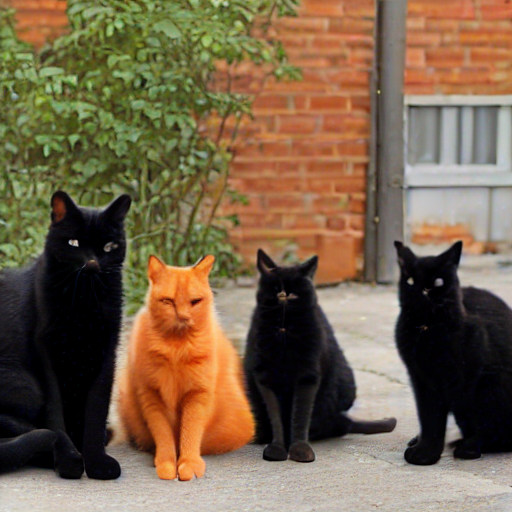

In [15]:
display(regenerated_image)

## **7.2. Case2**
- 이미지 일부 마스킹 후 재생성
- approach1, approach2 존재

### **7.2.1. Approach1: Dictionary**

In [ ]:
if case_num == 2:
    # return regenerated_image

### **7.2.2. Approach2: Graph**

In [ ]:
if case_num == 2:
    # return regenerated_image

# **8. Evaluation: CLIP**

In [16]:
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

c:\Users\miche\projects\TTI_Alignment\IG_venv\Lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\miche\.cache\huggingface\hub\models--openai--clip-vit-base-patch32. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [18]:
text = user_prompt # 비교할 문장 (여러 문장 비교 가능 -> 이러면 softmax로 얼마나 가까운지 확률 출력)
images = [original_image, regenerated_image] # 비교할 이미지 (여러 이미지 가능)

# 전처리
inputs = clip_processor(text=text, images=images, return_tensors="pt", padding=True)

# clip 점수 매기기
with torch.no_grad():
    outputs = clip_model(**inputs)
    image_embeds = outputs.image_embeds
    text_embeds = outputs.text_embeds

# 유사도 계산(cosine similarity)
similarities = F.cosine_similarity(image_embeds, text_embeds)
print(f"CLIP 유사도 점수: {similarities}")

CLIP 유사도 점수: tensor([0.3358, 0.3537])
